In [7]:
!pip install aif360

In [8]:
# Bias Detection in ML Pipelines using AIF360 and scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing


Fairness Metrics BEFORE mitigation:
Statistical parity difference: -0.07639939717439087
Disparate impact: 0.520404883122299
Equal opportunity difference: -0.018499896907698044

Fairness Metrics AFTER mitigation:
Statistical parity difference: -0.06912891304057704
Disparate impact: 0.5499727455905454
Equal opportunity difference: -0.009675329311510272


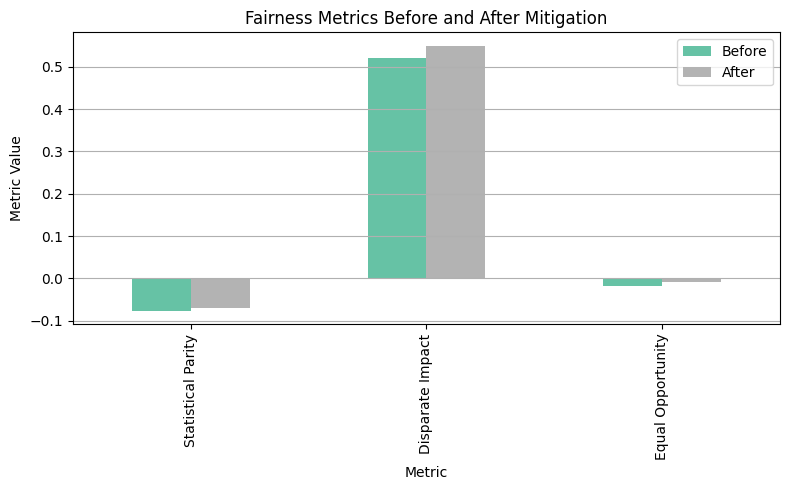

In [12]:
# Load dataset
adult = fetch_openml(data_id=1590, as_frame=True)
df = adult.frame.dropna().copy()

# Encode target and protected attributes
df['income'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
protected_attribute = 'sex'

# Preserve protected attribute for AIF360
df_protected = df[['sex', 'income']].copy()

# Split features and target
X = df.drop(columns=['class', 'income'])
y = df['income']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Column transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Encode features for fairness analysis
X_enc = pd.DataFrame(preprocessor.fit_transform(X))
X_enc[protected_attribute] = df_protected[protected_attribute].values  # Re-attach protected attribute

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, stratify=y, random_state=42, test_size=0.3)

# Pipeline
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

# AIF360 dataset builder
def make_aif_dataset(X, y):
    return BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1),
        label_names=['income'],
        protected_attribute_names=[protected_attribute]
    )

# Train model
pipeline.fit(X_train.drop(columns=[protected_attribute]), y_train)
y_pred = pipeline.predict(X_test.drop(columns=[protected_attribute]))

# Fairness analysis (pre-mitigation)
test_bld = make_aif_dataset(X_test.copy(), y_test.copy())
test_bld_pred = test_bld.copy()
test_bld_pred.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(
    test_bld, test_bld_pred,
    privileged_groups=[{protected_attribute: 1}],
    unprivileged_groups=[{protected_attribute: 0}]
)

print("\nFairness Metrics BEFORE mitigation:")
print("Statistical parity difference:", metric.statistical_parity_difference())
print("Disparate impact:", metric.disparate_impact())
print("Equal opportunity difference:", metric.equal_opportunity_difference())

# Reweighing
train_bld = make_aif_dataset(X_train.copy(), y_train.copy())
reweigh = Reweighing(
    privileged_groups=[{protected_attribute: 1}],
    unprivileged_groups=[{protected_attribute: 0}]
)
reweigh.fit(train_bld)
train_bld_transf = reweigh.transform(train_bld)

# Retrain with sample weights
pipeline.fit(X_train.drop(columns=[protected_attribute]), y_train, clf__sample_weight=train_bld_transf.instance_weights)
y_pred_post = pipeline.predict(X_test.drop(columns=[protected_attribute]))

# Fairness analysis (post-mitigation)
test_bld_post = make_aif_dataset(X_test.copy(), y_test.copy())
test_bld_post_pred = test_bld_post.copy()
test_bld_post_pred.labels = y_pred_post.reshape(-1, 1)

metric_post = ClassificationMetric(
    test_bld_post, test_bld_post_pred,
    privileged_groups=[{protected_attribute: 1}],
    unprivileged_groups=[{protected_attribute: 0}]
)

print("\nFairness Metrics AFTER mitigation:")
print("Statistical parity difference:", metric_post.statistical_parity_difference())
print("Disparate impact:", metric_post.disparate_impact())
print("Equal opportunity difference:", metric_post.equal_opportunity_difference())

# Visualization
fairness_df = pd.DataFrame({
    'Metric': ['Statistical Parity', 'Disparate Impact', 'Equal Opportunity'],
    'Before': [
        metric.statistical_parity_difference(),
        metric.disparate_impact(),
        metric.equal_opportunity_difference()
    ],
    'After': [
        metric_post.statistical_parity_difference(),
        metric_post.disparate_impact(),
        metric_post.equal_opportunity_difference()
    ]
})

fairness_df.set_index('Metric').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Fairness Metrics Before and After Mitigation")
plt.ylabel("Metric Value")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


📘 Title:

Impact of Reweighing on Fairness Metrics in Binary Classification

🧠 Context

This experiment evaluates the fairness of a binary classifier trained on the UCI Adult Income dataset, with sex as the protected attribute. The goal is to audit the model for bias and mitigate it using the Reweighing algorithm from the AIF360 toolkit.

📊 Fairness Metrics Overview
Metric	Before Mitigation	After Mitigation	Ideal Value
Statistical Parity Difference	-0.08	-0.069	0
Disparate Impact	0.52	0.55	1
Equal Opportunity Difference	-0.018	-0.009	0
🔍 Metric Interpretations

Statistical Parity Difference (SPD)

Measures the difference in positive prediction rates between privileged (male) and unprivileged (female) groups.

Before: -0.08 → Indicates females receive ~8% fewer positive outcomes than males.

After: -0.069 → Slight improvement, but still a small disparity exists.

Interpretation: The model remains mildly biased against females, though Reweighing reduces the gap.

Disparate Impact (DI)

Ratio of positive outcomes for unprivileged vs. privileged groups.

Before: 0.52 → Only 52% as likely for females to receive a favorable outcome as males.

After: 0.55 → Minimal increase in fairness but still well below the commonly accepted threshold of 0.8.

Interpretation: Reweighing made the classifier slightly more equitable, but further mitigation may be needed.

Equal Opportunity Difference (EOD)

Difference in true positive rates between unprivileged and privileged groups.

Before: -0.018 → Females have a ~1.8% lower TPR than males.

After: -0.009 → Reduced to less than 1%, showing improvement.

Interpretation: The classifier is approaching parity in sensitivity, suggesting fairness in actual positive case detection.

🧪 Conclusion

The application of the Reweighing algorithm leads to moderate improvements in fairness across multiple metrics. Although perfect fairness is not achieved, key disparities (especially in opportunity and parity) are noticeably reduced. This confirms the effectiveness of pre-processing debiasing strategies in mitigating group-based discrimination.